# Sprint 機械学習スクラッチ クラスタリング

In [2]:
import os 

import numpy as np
import pandas as pd

from sklearn.datasets import make_blobs

import matplotlib.pyplot as plt

In [3]:
X, _ = make_blobs(n_samples=100, n_features=2, centers=4, cluster_std=0.5, shuffle=True, random_state=0)

## 【問題1】中心点の初期値を決める
入力されたデータから 
K
 個の中心点 
μ
1
 から 
μ
K
 の初期値を決めるコードを作成してください。
K
 は指定したクラスタ数です。

最もシンプルな初期値の決定方法は、データ点 
X
n
 の中からランダムに 
K
 個選ぶことです。今回はこれを実装してください。

K-meansの学習結果は中心点 
μ
 の初期値に影響を受けます。そのため、学習時には複数個の初期値で計算を行います。

## 【問題2】SSEを求める関数の作成
クラスタ内誤差平方和（SSE, Sum of Squared Errors）を計算する関数を作成してください。

K-meansはこのSSEを最小化する 
r
n
k
 と 
μ
k
 を求めることが目的となります。複数個の初期値で計算したクラスタリング結果から、どれを最終的に採用するかを決める際にこのSSEを求める関数を使用します。

## 【問題3】クラスタへの割り当て
全てのデータ点 
X
n
 を最も近い中心点 
μ
k
 に割り当てるコードを作成してください。

K-menasにおける 近い とは点と点のユークリッド距離が小さくなることです。ユークリッド距離とはピタゴラスの定理（三平方の定理）で求められるものですが、ベクトル 
p
,
q
 に対しては以下の数式で表現できます。

## 【問題4】中心点の移動
中心点 
μ
k
 を 
k
 番目のクラスタに割り当てられる全てのデータ点 
X
n
 の平均値（重心）に移動するコードを作成してください。

クラスタの割り当て 
r
n
k
 を固定した上でSSEを最小化していることになりますが、SSE自体を求める必要はありません。

## 【問題5】繰り返し
クラスタへの割り当てと中心点の移動を繰り返すことで学習を行うコードを作成してください。

次のどれかの条件を満たしたらこれを止めます。

繰り返しが指定した回数に到達する。（雛形では引数max_iter）
中心点 
μ
k
 と重心の差が指定した許容値以下になる。（雛形では引数tol）


## 【問題6】異なる初期値で計算
問題5の繰り返しを、指定した回数初期値を変更して計算するコードを作成してください。回数は雛形では引数n_initで指定します。

複数計算した中でSSEが最小になったものが最終的な学習結果となるため、その時の中心点 
μ
k
 を保持しておきます。

## 【問題7】推定
新たなデータに対してどのクラスタに所属するかの推定の際は、学習時の1つ目のフェーズと同じことを行います。

データ点 
X
n
 と学習で決まった中心点 
μ
k
 に対し、 
S
S
E
 を最小化する 
r
n
k
 を選ぶ。

In [41]:
class ScratchKMeans():
    """
    K-meansのスクラッチ実装

    Parameters
    ----------
    n_clusters : int
      クラスタ数
    n_init : int
      中心点の初期値を何回変えて計算するか
    max_iter : int
      1回の計算で最大何イテレーションするか
    tol : float
      イテレーションを終了する基準となる中心点と重心の許容誤差
    verbose : bool
      学習過程を出力する場合はTrue
    """
    
    def __init__(self, n_clusters=4, n_init=1, max_iter=100, tol =1, verbose=False):
        # ハイパーパラメータを属性として記録
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol  = tol
        self.verbose = verbose
        
    def _initial_mean(self, data, n_clusters):
        """
        最初の中心点を決定する関数
        
        データの上から順にデータを取り出し、平均値を空のarrayに追加していく
        -------------------------
        引数
        data 
        n_clusters(クラスター数)
        --------------------------
        retrun
        中心点のarray (n_clusters, n_features)
        
        """
        mean_result_array = np.empty((0, data.shape[1]), int)
        array_list = []
        split_data_num = data.shape[0] / n_clusters
        for i in range(n_clusters):
            a = int(i * split_data_num)
            b = int(a + split_data_num)
            K_data = data[a:b, :]
            mean_result_array = np.append(mean_result_array, [K_data.mean(axis=0)], axis=0)
            
        return mean_result_array
    
    def _decision_class(self, X, mean_array):
        """
        データがどのクラスターに所属するかを決定する関数
        
        距離行列を作成する。
        それぞれのデータから各クラスターまでの距離を算出し、距離行列に追加
        最も小さい値のインデックスを取得
        
        ---------------------------------
        引数
        X:　データ array
        mean_array : 中心点のデータ　　array
        ----------------------------------
        return
        label_array:データの順番でクラスターの値が入っているarray
        
        """
        self.dis_array = np.empty((X.shape[0], mean_array.shape[0]), float)
        for n in range(X.shape[0]):
            for k in range(mean_array.shape[0]):
                self.dis_array[n , k] = np.linalg.norm(X[n] - mean_array[k])
                
        label_array  = np.argmin(self.dis_array, axis=1)
        return label_array
    
    def _new_mean(self, X, label_array, mean_array):
        """
        中心点を更新し、新しい中心点を返す関数
        
        クラスター毎にインデックスを取得し、そのデータを取り出す
        データの平均値を空のarrayに追加していく
        ----------------------------
        引数
        X : 元データ
        label_array:データの順番でクラスターの値が入っているarray
        mean_array:その時点での中心点
        -----------------------------
        return
        new_array_mean:新しい中心点のarray
        """
        new_array_mean = np.empty((0, X.shape[1]), float)
        for i in range(mean_array.shape[0]):
            k_index = np.where(label_array == i)
            k_data = X[k_index]
            k_mean = k_data.mean(axis=0)
            new_array_mean = np.append(new_array_mean, [k_mean], axis=0)
            
        return new_array_mean
    
    def _SSE(self, X, mean_array):
        """
        SSEを求める関数
        
        距離行列用の空のarrayを作成
        データから中心点までの距離を求め距離行列のarrayに追加
        その中で最小の値を取り出し、合計する
        -------------------------------
        引数
        X:データ
        mean_array:中心点のarray
        ------------------------------
        return
        self.SSE:SSEの値
        """
        self.SSE = np.empty((X.shape[0], mean_array.shape[0]), float)
        for k in range(mean_array.shape[0]):
            for n in range(X.shape[0]):
                self.SSE[n, k] = np.linalg.norm(X[n] - mean_array[k])
                
        self.SSE = np.amin(self.SSE, axis=1)
        
        return np.sum(self.SSE)
    
    def SSE_plot(self, num_class):
        """
        任意のクラスターの数に応じたグラフをプロットする関数
        
        設定したクラスターの数分だけ行う
        毎回適当な中心点を決め、その中心点に応じたSSEを取得し、リストに保存
        SSEをプロットする
        ---------------------------------
        引数
        num_class:設定したクラスター数
        _________________
        return
        
        """
        SSE_result_list = []
        for i in range(num_class):
            mean_result= self._initial_mean(X, i+1)
            SSE_result_list.append(self._SSE(self.X, mean_result))
            
        self.SSE_result_list = SSE_result_list
        plt.plot(SSE_result_list)

    def fit(self, X):
        """
        K-meansによるクラスタリングを計算
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        """
        #元のデータを保持する
        self.X = X.copy()
        
        #最初の中心点を適当に決めるにあたってデータをシャッフルする
        np.random.shuffle(X)
        
        
        decision_point = 1e10
        #最初の中心点を決定する
        for i in range(self.n_init):
            mean_array = self._initial_mean(X,  self.n_clusters)
            sse = self._SSE(X, mean_array)
            if sse < decision_point:
                decision_point = sse
                self.mean_array = mean_array
                
        #中心点を更新する
        for i in range(self.max_iter):
            new_label = self._decision_class(self.X, self.mean_array)
            if (self.mean_array - self._new_mean(self.X, new_label, self.mean_array)).any() < self.tol:
                break
            self.mean_array = self._new_mean(self.X, new_label, self.mean_array)
            
        self._SSE(self.X, self.mean_array)
            

        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print(self.mean_array)

    def predict(self, X):
        """
        入力されたデータがどのクラスタに属するかを計算
        """
        
        #self.mean_arrayに基づいたクラス分類を行う
        self.dis_array_result = np.empty((X.shape[0], self.mean_array.shape[0]), float)
        for n in range(X.shape[0]):
            for k in range(self.mean_array.shape[0]):
                self.dis_array_result[n , k] = np.linalg.norm(X[n] - self.mean_array[k])
                
        label_array  = np.argmin(self.dis_array_result, axis=1)
        
        return label_array

In [5]:
skm = ScratchKMeans()

In [6]:
skm.fit(X)

In [7]:
skm.SSE

array([0.64471883, 0.65931349, 0.43284435, 0.21126946, 0.88301701,
       0.22388804, 0.89430908, 0.50786889, 1.24705982, 0.17158362,
       0.81143441, 0.84948708, 0.51236944, 0.28185258, 0.5151549 ,
       1.24911132, 1.04435102, 1.17613645, 0.42618024, 0.93302326,
       1.40171995, 0.57310776, 0.43818742, 0.88699675, 0.43307654,
       0.53977176, 1.06202919, 0.13607807, 1.19435825, 0.67161591,
       0.36851615, 0.80155767, 0.30888758, 0.82783944, 0.36862486,
       0.49353581, 1.06147386, 0.56057535, 1.32694021, 0.74263063,
       0.71671383, 0.12352729, 1.08296942, 0.61888129, 0.48065021,
       0.7716055 , 0.51584758, 0.39098599, 0.31521223, 1.08518947,
       0.68332485, 0.10061224, 0.38734112, 0.77227996, 0.90139539,
       0.29743774, 0.6311439 , 0.42795772, 0.37387212, 0.65560102,
       0.63553054, 0.6585591 , 0.18383075, 1.08474207, 0.70759255,
       0.69569828, 0.82625632, 0.76084211, 0.4525277 , 0.30901166,
       0.64606709, 0.6448446 , 0.18433208, 0.22291534, 0.13604

In [8]:
skm.predict(X)

array([2, 2, 0, 1, 1, 1, 0, 2, 2, 0, 3, 1, 0, 0, 3, 2, 0, 0, 1, 0, 1, 0,
       1, 3, 2, 3, 0, 0, 0, 0, 2, 1, 3, 2, 1, 2, 3, 0, 2, 1, 1, 0, 3, 0,
       0, 1, 1, 3, 1, 0, 3, 1, 0, 1, 3, 2, 0, 1, 2, 2, 2, 1, 2, 0, 3, 2,
       2, 1, 3, 0, 1, 0, 2, 3, 3, 3, 1, 2, 1, 1, 3, 1, 2, 0, 2, 3, 3, 2,
       3, 3, 3, 2, 2, 3, 0, 2, 3, 1, 3, 3])

## 【問題8】エルボー法の実装
K-meansにおいて中心点の個数 
k
 は人為的に決める必要がありますが、その判断方法としてエルボー法があります。エルボー法により中心点の個数 
k
 を検討するためのコードを作成してください。

SSEを縦軸、クラスタ数 
k
 を横軸にした折れ線グラフを表示します。このためにK-meansのインスタンスからはSSEを取得できるようにしてください。

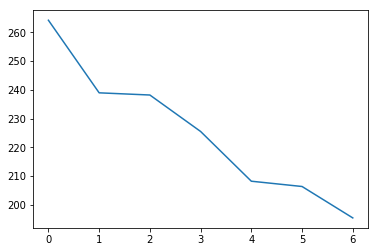

In [9]:
skm.SSE_plot(7)

このグラフからは谷は５個になっており、クラスター数は５個が良いと考えられる。  
しかし、クラスタ数を増やせば増やすほどSSEの値が減少していると思われる。

# 卸売業者のデータ分析
クラスタリングを利用法を学ぶために、Wholesale customers Data Setを使用します。

UCI Machine Learning Repository: Wholesale customers Data Set

Data Folderの中からWholesale customers data.csvをダウンロードしてください。これはポルトガルのリスボンにある卸売業者（wholesale）が顧客から集めたデータです。中身は各顧客が年間でミルクや食料品を何ユーロ購入しているかというデータになっています。顧客は小売店やレストランです。RegionとChannelは取り覗き、金額のデータでK-meansを利用します。

In [10]:
data = pd.read_csv("/Users/morishuuya/Desktop/dataset/DIC/Wholesale_customers_data.csv")

In [11]:
data_drop = data.drop(columns = ["Channel", "Region"])

In [12]:
data_drop_log = np.log(data_drop)

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca = pca.fit(data_drop_log)
data_pca = pca.transform(data_drop_log)

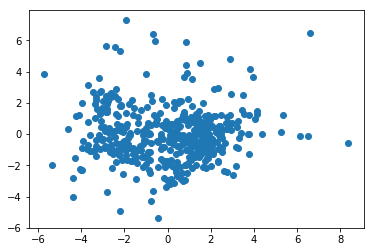

In [14]:
plt.scatter(data_pca[:, 0], data_pca[:, 1])

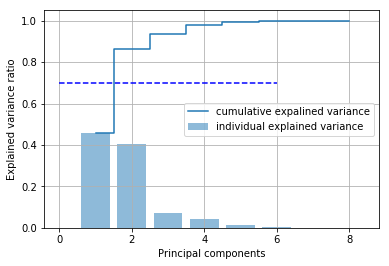

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=None)
pca = pca.fit(data)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
#print(cum_var_exp)
plt.bar(np.arange(1,9), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(np.arange(1,9), cum_var_exp, where='mid', label='cumulative expalined variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.hlines(0.7, 0, 6,  "blue", linestyles='dashed')
plt.legend(loc='best')
plt.grid()
plt.show()

## 【問題10】クラスタ数kの選択
最適だと思われるクラスタ数 
k
 を選択してください。エルボー法やシルエット図を活用する他、人間が後々どう利用したいのかも選択に関わってきます。選択した上で、なぜそれを選んだか説明してください。

In [16]:
skm_data = ScratchKMeans()

In [17]:
skm_data.fit(data_pca)

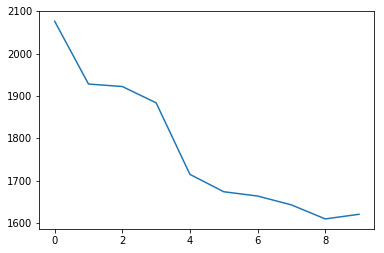

In [40]:
skm_data.SSE_plot(10)

<pre>
クラスター数を増やせばSSEの値は下がっていくが、クラスタ分類後の分析が煩雑になることを考えあまり多くはしたくない。
グラフからエルボー法より4個で試してみる

In [19]:
skm_2_clusters = ScratchKMeans(n_clusters = 4)

In [20]:
skm_2_clusters.fit(data_pca)

In [21]:
y_pred_data2 = skm_2_clusters.predict(data_pca)

## 【問題11】既知のグループとの比較
RegionとChannelはK-meansに使用しなかったが、これれらは既知のグループです。クラスタとこれら既知のグループがどう違うかを確認し、説明してください。まずはそれぞれを可視化してください。

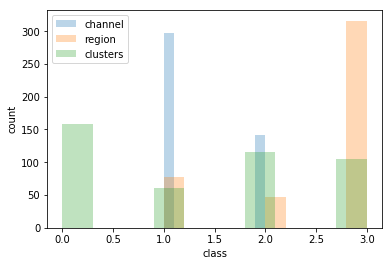

In [22]:
plt.hist(data.loc[:,"Channel" ], alpha = 0.3, label="channel")
plt.hist(data.loc[:,"Region" ], alpha = 0.3, label="region")
plt.hist(y_pred_data2, alpha = 0.3, label="clusters")
plt.xlabel("class")
plt.ylabel("count")
plt.legend()
plt.show()

<pre>
channel:2, region:2, cluster:2の集団は比較的数が似ている

## 【問題12】卸売業者にとって有益な情報
卸売業者にとって有益な情報を探し出し文章にまとめてください。

In [23]:
data_2 = data.copy()

In [24]:
data_2["cluster"] = y_pred_data2

In [36]:
data_2

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,cluster
0,2,3,12669,9656,7561,214,2674,1338,2
1,2,3,7057,9810,9568,1762,3293,1776,1
2,2,3,6353,8808,7684,2405,3516,7844,0
3,1,3,13265,1196,4221,6404,507,1788,2
4,2,3,22615,5410,7198,3915,1777,5185,2
5,2,3,9413,8259,5126,666,1795,1451,0
6,2,3,12126,3199,6975,480,3140,545,0
7,2,3,7579,4956,9426,1669,3321,2566,2
8,1,3,5963,3648,6192,425,1716,750,0
9,2,3,6006,11093,18881,1159,7425,2098,3


In [32]:
data_2.groupby(["Channel", "Region", "cluster"]).mean().round()

Fresh     Milk  Grocery  Frozen  Detergents_Paper  \
Channel Region cluster                                                        
1       1      0        11323.0   2397.0   3272.0  2060.0             778.0   
               1        13594.0   3181.0   3822.0  4570.0            1316.0   
               2        13793.0   4615.0   4569.0  3287.0            1184.0   
               3        13475.0   5542.0   4513.0  3484.0             579.0   
        2      0        10295.0   2987.0   4298.0  8643.0             481.0   
               1        11036.0   1765.0   3895.0  6883.0              79.0   
               2        16357.0   1829.0   5176.0  2892.0             742.0   
               3         8168.0   1955.0   3783.0  3667.0             342.0   
        3      0        13621.0   3730.0   4456.0  3595.0             968.0   
               1        13799.0   3947.0   4602.0  3318.0             485.0   
               2        13812.0   3221.0   3434.0  3994.0             779.0   
               3        14355.0   3153.0   3131.0  3594.0             700.0   
2       1      0         3959.0  11168.0  20370.0  2521.0            9011.0   
               1         4631.0  11317.0  16623.0  3339.0            7874.0   
               2         9565.0   8400.0  12448.0  1179.0            6982.0   
               3         4904.0  11433.0  21899.0  3152.0            7843.0   
        2      0         9343.0   9996.0  26283.0   644.0           15810.0   
               1         2886.0   5302.0   9785.0   364.0            6236.0   
               2         9728.0   6454.0  10169.0  2892.0            5856.0   
               3         4985.0  11327.0  16784.0  1122.0            6898.0   
        3      0         9532.0   9636.0  12411.0  1314.0            5322.0   
               1         9967.0  12256.0  19531.0  2020.0            8574.0   
               2         9855.0  11457.0  17940.0  1442.0            8222.0   
               3        10236.0  11929.0  17451.0  1613.0            6998.0   

                        Delicassen  
Channel Region cluster              
1       1      0             793.0  
               1            1362.0  
               2            1156.0  
               3            1778.0  
        2      0            1280.0  
               1             900.0  
               2            1018.0  
               3            1006.0  
        3      0            1358.0  
               1            2773.0  
               2            1147.0  
               3            1433.0  
2       1      0            2677.0  
               1            1404.0  
               2            1047.0  
               3            1174.0  
        2      0            1226.0  
               1             555.0  
               2            1208.0  
               3            1354.0  
        3      0            1529.0  
               1            1934.0  
               2            1930.0  
               3            2151.0

In [27]:
data_2_groupby_cluster = data_2.groupby(["cluster"]).mean().round()

In [37]:
data_2_groupby_cluster

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
cluster,,,,,,,,
0,1.0,3.0,11480.0,5548.0,7675.0,3055.0,2796.0,1391.0
1,1.0,3.0,11910.0,6275.0,8997.0,3312.0,3156.0,2140.0
2,1.0,2.0,12743.0,5572.0,7698.0,3078.0,2998.0,1322.0
3,1.0,3.0,12015.0,6139.0,8040.0,2951.0,2721.0,1592.0


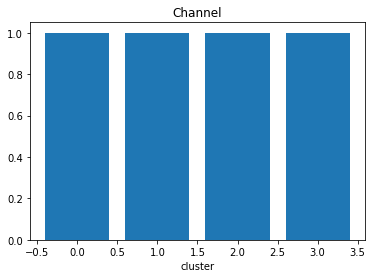

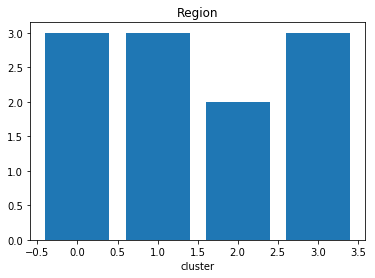

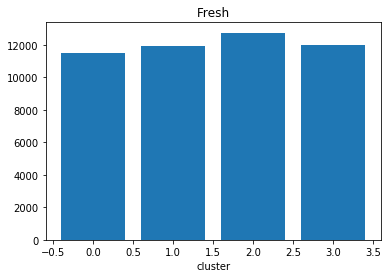

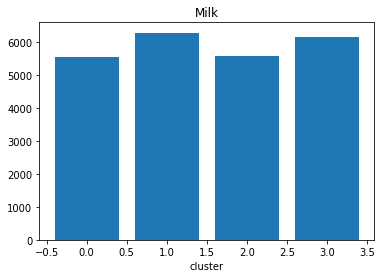

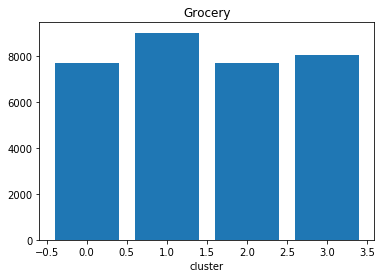

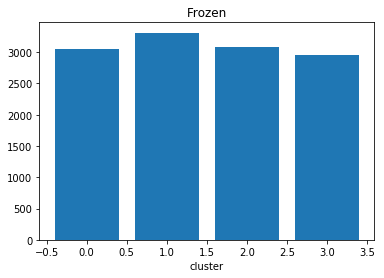

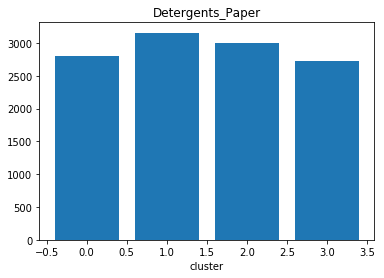

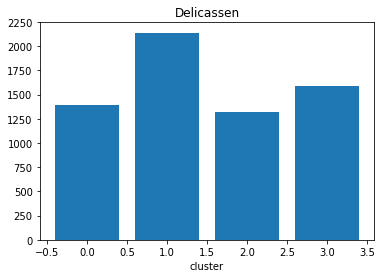

In [29]:
for col in data_2_groupby_cluster :
    plt.title(col)
    plt.xlabel("cluster")
    plt.bar(x = [0, 1, 2, 3], height=data_2_groupby_cluster[col])
    plt.show()

<pre>
cluster:１の人は, cluster:2, cluster3に比べ消費しやすい
特にDelicassenは顕著に高い
cluster:1の人はchannel:1の人が多い


channel:2の中でcluster:0の人はDetergents_Paperをよく購入する、しかしregion:3の人はあまり購入しない。

cluster:1の人はchannel:1の人が多く、このセクションの購入が多いため、ホテル・レストランに向けたプロモーションを強化する

channel:2でcluster:0の人のDetergents_Paperの購入が多い、一方region:3の人が高くない。  
なので、リスボン・ポルトでの個人向けDetergents_Paperの広告を増やす、特にcluster:0の人の特徴に合わせて行う。